# Exercise 3

## Imports

In [1]:
import time
import os
import transformers
import optuna
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import log_loss, balanced_accuracy_score

## Data loading

In [2]:
ag_news_train_df = pd.read_csv('data/ag_news_train.csv')
ag_news_test_df = pd.read_csv('data/ag_news_test.csv')
amazon_reviews_df = pd.read_csv('data/cleaned_amazon_reviews.csv')

In [3]:
ag_news_train_df.shape

(120000, 3)

In [4]:
ag_news_test_df.shape

(7600, 3)

In [5]:
ag_news_train_df.head()

,Class Index,Title,Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


In [6]:
amazon_reviews_df.shape

(17340, 4)

In [7]:
amazon_reviews_df.head()

,sentiments,cleaned_review,cleaned_review_length,review_score
0,positive,i wish would have gotten one earlier love it a...,19,5.0
1,neutral,i ve learned this lesson again open the packag...,88,1.0
2,neutral,it is so slow and lags find better option,9,2.0
3,neutral,roller ball stopped working within months of m...,12,1.0
4,neutral,i like the color and size but it few days out ...,21,1.0


In [8]:
amazon_reviews_df.isna().sum()

sentiments               0
cleaned_review           3
cleaned_review_length    0
review_score             0
dtype: int64

<AxesSubplot:>

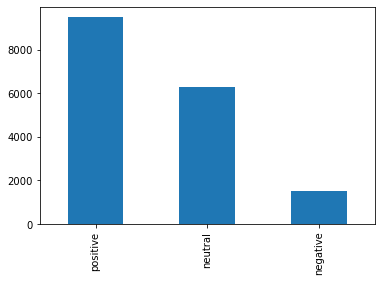

In [9]:
amazon_reviews_df.sentiments.value_counts().plot(kind='bar')

Unbalanced target

<AxesSubplot:>

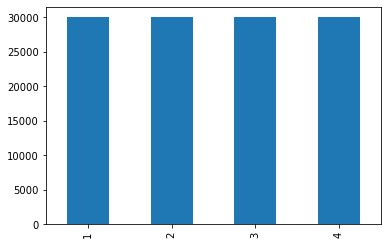

In [10]:
ag_news_train_df['Class Index'].value_counts().plot(kind='bar')

Balanced target

#### Distribution of review lengths

(array([1.4993e+04, 1.8380e+03, 3.4300e+02, 8.3000e+01, 5.0000e+01,
        1.2000e+01, 9.0000e+00, 5.0000e+00, 4.0000e+00, 3.0000e+00]),
 array([  0. ,  57.1, 114.2, 171.3, 228.4, 285.5, 342.6, 399.7, 456.8,
        513.9, 571. ]),
 <BarContainer object of 10 artists>)

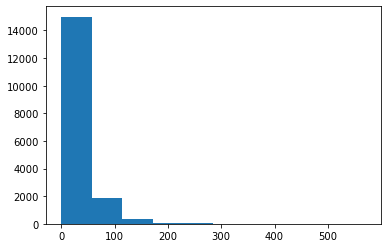

In [11]:
plt.hist(amazon_reviews_df.cleaned_review_length)

#### Distribution of the news article lengths

(array([4.8100e+03, 6.7638e+04, 4.1664e+04, 4.2770e+03, 1.0700e+03,
        2.9800e+02, 9.3000e+01, 9.0000e+01, 2.9000e+01, 3.1000e+01]),
 array([  6. , 103.9, 201.8, 299.7, 397.6, 495.5, 593.4, 691.3, 789.2,
        887.1, 985. ]),
 <BarContainer object of 10 artists>)

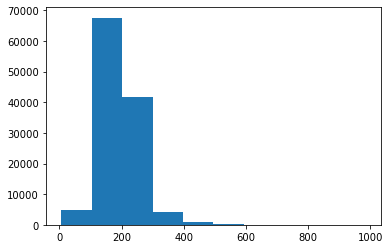

In [12]:
plt.hist(ag_news_train_df.Description.str.len())

In [13]:
ag_news_train_df.isna().any()

Class Index    False
Title          False
Description    False
dtype: bool

#### Removing NaNs

In [14]:
amazon_reviews_df.dropna(inplace=True)

### Splitting amazon reviews into train and test set

In [15]:
X_amazon_reviews = amazon_reviews_df.drop(columns=['sentiments'])
y_amazon_reviews = amazon_reviews_df['sentiments']

In [16]:
X_train_reviews, X_test_reviews, y_train_reviews, y_test_reviews = train_test_split(X_amazon_reviews,
                                                                                   y_amazon_reviews,
                                                                                   random_state=42,
                                                                                   test_size=0.2)

In [17]:
X_train_reviews, X_valid_reviews, y_train_reviews, y_valid_reviews = train_test_split(X_train_reviews,
                                                                                     y_train_reviews,
                                                                                     random_state=42,
                                                                                     test_size = 0.33)

### Splitting ag news into X and y's

Merging Title and Description into one field, "Text"

In [18]:
ag_news_train_df['Text'] = ag_news_train_df[['Title', 'Description']].agg(' '.join,axis=1)
ag_news_test_df['Text'] = ag_news_test_df[['Title', 'Description']].agg(' '.join,axis=1)

In [19]:
ag_news_train_df['Text']

0         Wall St. Bears Claw Back Into the Black (Reute...
1         Carlyle Looks Toward Commercial Aerospace (Reu...
2         Oil and Economy Cloud Stocks' Outlook (Reuters...
3         Iraq Halts Oil Exports from Main Southern Pipe...
4         Oil prices soar to all-time record, posing new...
                                ...                        
119995    Pakistan's Musharraf Says Won't Quit as Army C...
119996    Renteria signing a top-shelf deal Red Sox gene...
119997    Saban not going to Dolphins yet The Miami Dolp...
119998    Today's NFL games PITTSBURGH at NY GIANTS Time...
119999    Nets get Carter from Raptors INDIANAPOLIS -- A...
Name: Text, Length: 120000, dtype: object

In [20]:
X_train_news = ag_news_train_df['Text']
y_train_news = ag_news_train_df['Class Index']

X_test_news = ag_news_test_df['Text']
y_test_news = ag_news_test_df['Class Index']

In [21]:
X_train_news, X_valid_news, y_train_news, y_valid_news = train_test_split(X_train_news,
                                                                          y_train_news,
                                                                          random_state=42,
                                                                          test_size = 0.33)

## Naive feature extraction

### Uni-Bigram vectorizer

Because documents are quite short on average, we used the uni-bigram vectorizer (contains both unigrams and bigrams)

Following pieces of code were taken from Sklearn's text feature extraction tutorial. (https://scikit-learn.org/stable/modules/feature_extraction.html)

In [22]:
from sklearn.feature_extraction.text import CountVectorizer

In [23]:
bigram_vectorizer = CountVectorizer(ngram_range=(1,2), token_pattern=r'\b\w+\b', min_df=1)

In [24]:
X_train_reviews_tr = bigram_vectorizer.fit_transform(X_train_reviews.cleaned_review)
X_valid_reviews_tr = bigram_vectorizer.transform(X_valid_reviews.cleaned_review)
X_test_reviews_tr = bigram_vectorizer.transform(X_test_reviews.cleaned_review)

In [25]:
bigram_vectorizer.get_feature_names()

['a',
 'a bit',
 'a bunch',
 'a dependable',
 'a fantastic',
 'a flimsy',
 'a friend',
 'a gift',
 'a good',
 'a great',
 'a little',
 'a month',
 'a pretty',
 'a solid',
 'a sweet',
 'a tad',
 'a very',
 'a well',
 'aa',
 'aa batteries',
 'aa battery',
 'aaa',
 'aaa batteries',
 'aaa battery',
 'aaaaaaaaaaaahhhh',
 'aaaaaaaaaaaahhhh hear',
 'aaron',
 'aaron diehl',
 'aasdbvdb',
 'abd',
 'abd if',
 'abilities',
 'abilities after',
 'abilities but',
 'abilities over',
 'ability',
 'ability and',
 'ability cause',
 'ability it',
 'ability on',
 'ability to',
 'ability with',
 'abit',
 'abit better',
 'abit more',
 'abit of',
 'able',
 'able to',
 'about',
 'about accuracy',
 'about activating',
 'about all',
 'about almost',
 'about am',
 'about an',
 'about and',
 'about anywhere',
 'about as',
 'about away',
 'about background',
 'about bad',
 'about battery',
 'about being',
 'about but',
 'about buying',
 'about changing',
 'about constantly',
 'about day',
 'about days',
 'about dea

In [26]:
X_train_news_tr = bigram_vectorizer.fit_transform(X_train_news)
X_valid_news_tr = bigram_vectorizer.transform(X_valid_news)
X_test_news_tr = bigram_vectorizer.transform(X_test_news)

## Training shallow models

Balanced accuracy score is used to macro average across classes.

For hyperparam tuning only a half of training data will be used for performance reasons.

In [40]:
np.random.seed(42)

reviews_train_idx = np.random.choice(y_train_reviews.shape[0], 
                                     replace=False, size=y_train_reviews.shape[0]//2)
news_train_idx = np.random.choice(y_train_news.shape[0], 
                                     replace=False, size=y_train_news.shape[0]//16)
news_train_eighth_idx = np.random.choice(y_train_news.shape[0], 
                                     replace=False, size=y_train_news.shape[0]//8)


In [41]:
X_train_reviews_half = X_train_reviews_tr[reviews_train_idx,:]
y_train_reviews_half = y_train_reviews.iloc[reviews_train_idx]

X_train_news_16th = X_train_news_tr[news_train_idx,:]
y_train_news_16th = y_train_news.iloc[news_train_idx]

X_train_news_8th = X_train_news_tr[news_train_eighth_idx,:]
y_train_news_8th = y_train_news.iloc[news_train_eighth_idx]

#### Checking if models are saved

In [29]:
best_model_nn_reviews_is_saved = os.path.exists('models/best_model_nn_reviews.sav')
best_model_nn_news_is_saved = os.path.exists('models/best_model_nn_news.sav')
best_model_svm_reviews_is_saved = os.path.exists('models/best_model_svm_reviews.sav')
best_model_svm_news_is_saved = os.path.exists('models/best_model_svm_news.sav')


### Shallow NN (One layer perceptron)

#### Reviews dataset

In [30]:
available_activations = ['relu', 'logistic', 'tanh']
available_solvers = ['adam', 'lbfgs']
def objective(trial: optuna.trial.Trial):
    size_of_hidden_layer = trial.suggest_int('size_of_hidden_layer', 10, 100)
    alpha = trial.suggest_float('alpha', 0.0001, 0.001)
    activation = trial.suggest_categorical('activation', 
                                           choices=available_activations)
    solver = trial.suggest_categorical('solver', 
                                           choices=available_solvers)
    
    print(f"Trying: {size_of_hidden_layer}, {alpha}, {activation}, {solver}")
    model = MLPClassifier(hidden_layer_sizes=tuple([size_of_hidden_layer]),
                          alpha=alpha,
                          activation = activation,
                          max_iter=20,
                          solver=solver,
                          verbose=True,
                          learning_rate='adaptive',
                          random_state=42)
    model.fit(X_train_reviews_half, y_train_reviews_half)
    y_pred_probas = model.predict_proba(X_valid_reviews_tr)
    return log_loss(y_valid_reviews, y_pred_probas)


if not best_model_nn_reviews_is_saved:
    study_nn_reviews = optuna.create_study(direction='minimize')
    # optuna.logging.set_verbosity(optuna.logging.DEBUG)
    study_nn_reviews.optimize(objective, n_trials=10,show_progress_bar=True,n_jobs=-1)

    study_nn_reviews.best_params

{'size_of_hidden_layer': 85,
 'alpha': 0.00045434026867030927,
 'activation': 'logistic',
 'solver': 'adam'}

In [31]:
if not best_model_nn_reviews_is_saved:
    best_model_nn_reviews = MLPClassifier(hidden_layer_sizes=(85,), 
                              alpha=0.00045434026867030927,
                              solver='adam',
                              activation='logistic',
                                random_state=42,
                               learning_rate='adaptive',
                               verbose=True,
                              max_iter=50,
                          )
    best_model_nn_reviews.fit(X_train_reviews_tr, y_train_reviews)


In [32]:
if not best_model_nn_reviews_is_saved:
    pickle.dump(best_model_nn_reviews, open('models/best_model_nn_reviews.sav', 'wb'))
    best_model_nn_reviews_is_saved = True
else:
    best_model_nn_reviews=pickle.load(open('models/best_model_nn_reviews.sav', 'rb'))

In [33]:
y_preds_nn_reviews = best_model_nn_reviews.predict(X_valid_reviews_tr)

balanced_acc_shallow_nn_reviews = balanced_accuracy_score(y_valid_reviews, y_preds_nn_reviews)

In [34]:
balanced_acc_shallow_nn_reviews

0.7584863114952708

Reviews:
Baseline of shallow NNs (balanced accuracy = average of recalls for each class): __0.758__

#### News dataset

In [35]:
available_activations = ['relu', 'logistic', 'tanh']
available_solvers = ['adam', 'lbfgs']
def objective(trial: optuna.trial.Trial):
    size_of_hidden_layer = trial.suggest_int('size_of_hidden_layer', 10, 100)
    alpha = trial.suggest_float('alpha', 0.0001, 0.001)
    activation = trial.suggest_categorical('activation', 
                                           choices=available_activations)
    solver = trial.suggest_categorical('solver', 
                                           choices=available_solvers)
    
    print(f"Trying: {size_of_hidden_layer}, {alpha}, {activation}, {solver}")
    model = MLPClassifier(hidden_layer_sizes=tuple([size_of_hidden_layer]),
                          alpha=alpha,
                          activation = activation,
                          max_iter=20,
                          solver=solver,
                          verbose=True,
                          learning_rate='adaptive',
                          random_state=42)
    model.fit(X_train_news_16th, y_train_news_16th)
    y_pred_probas = model.predict_proba(X_valid_news_tr)
    return log_loss(y_valid_news, y_pred_probas)

if not best_model_nn_news_is_saved:
    study_nn_news = optuna.create_study(direction='minimize')
    # optuna.logging.set_verbosity(optuna.logging.DEBUG)
    study_nn_news.optimize(objective, n_trials=10,show_progress_bar=True,n_jobs=2)

    study_nn_news.best_params

[I 2023-02-10 14:11:06,659] A new study created in memory with name: no-name-bd127e2d-c62b-4141-b4dc-fc454cf68a13
D:\Anaconda\lib\site-packages\optuna\progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/10 [00:00<?, ?it/s]

Trying: 84, 0.0006358917507602908, relu, adam
Trying: 90, 0.00031470281720136857, tanh, adam
Iteration 1, loss = 0.89443927
Iteration 1, loss = 0.78732110
Iteration 2, loss = 0.10724975
Iteration 2, loss = 0.06175298
Iteration 3, loss = 0.02549712
Iteration 3, loss = 0.01533005
Iteration 4, loss = 0.01238633
Iteration 4, loss = 0.00883988
Iteration 5, loss = 0.00851856
Iteration 5, loss = 0.00606122
Iteration 6, loss = 0.00636737
Iteration 6, loss = 0.00477340
Iteration 7, loss = 0.00508766
Iteration 7, loss = 0.00398493
Iteration 8, loss = 0.00435352
Iteration 8, loss = 0.00358742
Iteration 9, loss = 0.00379657
Iteration 9, loss = 0.00294925
Iteration 10, loss = 0.00359559
Iteration 10, loss = 0.00255747
Iteration 11, loss = 0.00335122
Iteration 11, loss = 0.00230461
Iteration 12, loss = 0.00305547
Iteration 12, loss = 0.00209745
Iteration 13, loss = 0.00262316
Iteration 13, loss = 0.00187329
Iteration 14, loss = 0.00242804
Iteration 14, loss = 0.00168378
Iteration 15, loss = 0.002313

D:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2023-02-10 14:50:30,035] Trial 0 finished with value: 0.3747170768048675 and parameters: {'size_of_hidden_layer': 84, 'alpha': 0.0006358917507602908, 'activation': 'relu', 'solver': 'adam'}. Best is trial 0 with value: 0.3747170768048675.
Trying: 65, 0.0005715482100200712, logistic, adam
Iteration 19, loss = 0.00127633
Iteration 1, loss = 1.27518631
Iteration 20, loss = 0.00122812


D:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2023-02-10 14:52:35,250] Trial 1 finished with value: 0.37968590251405715 and parameters: {'size_of_hidden_layer': 90, 'alpha': 0.00031470281720136857, 'activation': 'tanh', 'solver': 'adam'}. Best is trial 0 with value: 0.3747170768048675.
Trying: 72, 0.0005334905896163569, tanh, lbfgs
Iteration 2, loss = 0.86271048
Iteration 3, loss = 0.53771692


D:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Iteration 4, loss = 0.31855468
[I 2023-02-10 16:28:55,529] Trial 3 finished with value: 0.9763752760634413 and parameters: {'size_of_hidden_layer': 72, 'alpha': 0.0005334905896163569, 'activation': 'tanh', 'solver': 'lbfgs'}. Best is trial 0 with value: 0.3747170768048675.
Trying: 86, 0.0004345360365538965, tanh, adam
Iteration 5, loss = 0.19460593
Iteration 1, loss = 0.81144863
Iteration 6, loss = 0.12695809
Iteration 2, loss = 0.08162914
Iteration 7, loss = 0.08936824
Iteration 3, loss = 0.02093596
Iteration 8, loss = 0.06712168
Iteration 9, loss = 0.05350128
Iteration 4, loss = 0.01217000
Iteration 10, loss = 0.04452083
Iteration 5, loss = 0.00890737
Iteration 11, loss = 0.03809748
Iteration 6, loss = 0.00685254
Iteration 12, loss = 0.03348711
Iteration 13, loss = 0.03005086
Iteration 7, loss = 0.00529566
Iteration 14, loss = 0.02738558
Iteration 8, loss = 0.00414780
Iteration 15, loss = 0.02526864
Iteration 9, loss = 0.00348159
Iteration 16, loss = 0.02358077
Iteration 10, loss = 0

D:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2023-02-10 16:56:33,776] Trial 2 finished with value: 0.38012967188474134 and parameters: {'size_of_hidden_layer': 65, 'alpha': 0.0005715482100200712, 'activation': 'logistic', 'solver': 'adam'}. Best is trial 0 with value: 0.3747170768048675.
Trying: 58, 0.0007956599433048955, logistic, lbfgs
Iteration 13, loss = 0.00237088


D:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[I 2023-02-10 17:39:18,835] Trial 5 finished with value: 0.7932006670374889 and parameters: {'size_of_hidden_layer': 58, 'alpha': 0.0007956599433048955, 'activation': 'logistic', 'solver': 'lbfgs'}. Best is trial 0 with value: 0.3747170768048675.
Trying: 63, 0.0007284361569054989, logistic, lbfgs
Iteration 14, loss = 0.00219602
Iteration 15, loss = 0.00208821


D:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[I 2023-02-10 18:31:34,165] Trial 6 finished with value: 0.711844756454779 and parameters: {'size_of_hidden_layer': 63, 'alpha': 0.0007284361569054989, 'activation': 'logistic', 'solver': 'lbfgs'}. Best is trial 0 with value: 0.3747170768048675.
Trying: 34, 0.0004980605929484772, tanh, adam
Iteration 16, loss = 0.00195590
Iteration 1, loss = 0.95219356
Iteration 2, loss = 0.19479309
Iteration 17, loss = 0.00187977
Iteration 3, loss = 0.06796541
Iteration 4, loss = 0.03419110
Iteration 18, loss = 0.00177837
Iteration 5, loss = 0.02204393
Iteration 6, loss = 0.01598316
Iteration 7, loss = 0.01296085
Iteration 19, loss = 0.00171016
Iteration 8, loss = 0.01043513
Iteration 9, loss = 0.00812893
Iteration 20, loss = 0.00165348


D:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2023-02-10 18:39:34,789] Trial 4 finished with value: 0.37579377776875517 and parameters: {'size_of_hidden_layer': 86, 'alpha': 0.0004345360365538965, 'activation': 'tanh', 'solver': 'adam'}. Best is trial 0 with value: 0.3747170768048675.
Trying: 15, 0.0004922823756848594, logistic, lbfgs
Iteration 10, loss = 0.00679459


D:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[I 2023-02-10 18:40:35,593] Trial 8 finished with value: 0.5264591584465401 and parameters: {'size_of_hidden_layer': 15, 'alpha': 0.0004922823756848594, 'activation': 'logistic', 'solver': 'lbfgs'}. Best is trial 0 with value: 0.3747170768048675.
Trying: 43, 0.0009245844118927594, logistic, lbfgs
Iteration 11, loss = 0.00589013


D:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[I 2023-02-10 18:43:34,228] Trial 9 finished with value: 0.6065623922949059 and parameters: {'size_of_hidden_layer': 43, 'alpha': 0.0009245844118927594, 'activation': 'logistic', 'solver': 'lbfgs'}. Best is trial 0 with value: 0.3747170768048675.
Iteration 12, loss = 0.00524767
Iteration 13, loss = 0.00461006
Iteration 14, loss = 0.00419559
Iteration 15, loss = 0.00382025
Iteration 16, loss = 0.00352761
Iteration 17, loss = 0.00327008
Iteration 18, loss = 0.00376290
Iteration 19, loss = 0.00285495
Iteration 20, loss = 0.00269910


D:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2023-02-10 18:47:59,830] Trial 7 finished with value: 0.3686714944409208 and parameters: {'size_of_hidden_layer': 34, 'alpha': 0.0004980605929484772, 'activation': 'tanh', 'solver': 'adam'}. Best is trial 7 with value: 0.3686714944409208.


In [38]:
study_nn_news.best_value

0.3686714944409208

best value: 0.3686714944409208 (log loss)
 
best params:
{'size_of_hidden_layer': 34,
 'alpha': 0.0004980605929484772,
 'activation': 'tanh',
 'solver': 'adam'}

In [42]:
if not best_model_nn_news_is_saved:
    best_model_nn_news = MLPClassifier(hidden_layer_sizes=(34,), 
                              alpha=0.0004980605929484772,
                              solver='adam',
                              activation='tanh',
                                random_state=42,
                               learning_rate='adaptive',
                               verbose=True,
                              max_iter=20,
                          )
    best_model_nn_news.fit(X_train_news_8th, y_train_news_8th)


Iteration 1, loss = 0.73232100
Iteration 2, loss = 0.11048733
Iteration 3, loss = 0.03403315
Iteration 4, loss = 0.01827902
Iteration 5, loss = 0.01252437
Iteration 6, loss = 0.00940702
Iteration 7, loss = 0.00756440
Iteration 8, loss = 0.00633131
Iteration 9, loss = 0.00568283
Iteration 10, loss = 0.00480833
Iteration 11, loss = 0.00441195
Iteration 12, loss = 0.00407887
Iteration 13, loss = 0.00399694
Iteration 14, loss = 0.00347134
Iteration 15, loss = 0.00329088
Iteration 16, loss = 0.00315138
Iteration 17, loss = 0.00279531
Iteration 18, loss = 0.00266400
Iteration 19, loss = 0.00269408
Iteration 20, loss = 0.00285858


D:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


In [45]:
if not best_model_nn_news_is_saved:
    pickle.dump(best_model_nn_news, open('models/best_model_nn_news.sav', 'wb'))
    best_model_nn_news_is_saved = True
else:
    best_model_nn_news=pickle.load(open('models/best_model_nn_news.sav', 'rb'))

In [43]:
y_preds_nn_news = best_model_nn_news.predict(X_valid_news_tr)

balanced_acc_shallow_nn_news = balanced_accuracy_score(y_valid_news, y_preds_nn_news)

In [44]:
balanced_acc_shallow_nn_news

0.8971229026985744

News Baseline of shallow NNs (balanced accuracy = average of recalls for each class): __0.92__

### SVM

#### Reviews dataset

In [74]:
from sklearn.svm import SVC  
from sklearn.metrics import classification_report, confusion_matrix 

In [79]:
available_kernels = ['poly', 'sigmoid', 'linear']
def objective(trial: optuna.trial.Trial):
    kernel = trial.suggest_categorical('kernel', 
                                           choices=available_kernels)
    degree = trial.suggest_int('degree', 3,6)
    print(f"Trying: {kernel}")
    model = SVC(kernel=kernel,
                degree=degree,
                gamma='scale',
               verbose=True,
               probability=True,
               random_state=42)
    model.fit(X_train_reviews_tr, y_train_reviews)
    y_pred_probas = model.predict_proba(X_valid_reviews_tr)
    return log_loss(y_valid_reviews, y_pred_probas)

if not best_model_svm_reviews_is_saved:
    study_svm_reviews = optuna.create_study(direction='minimize')
    # optuna.logging.set_verbosity(optuna.logging.DEBUG)
    study_svm_reviews.optimize(objective, n_trials=5,show_progress_bar=True,n_jobs=-1)

    study_svm_reviews.best_params

[I 2023-02-04 20:18:53,511] A new study created in memory with name: no-name-93a41a8d-ccee-49c5-8a06-2fb1ab79644b
D:\Anaconda\lib\site-packages\optuna\progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/5 [00:00<?, ?it/s]

Trying: poly
[LibSVM][I 2023-02-04 20:22:08,231] Trial 0 finished with value: 0.9070452498701899 and parameters: {'kernel': 'poly', 'degree': 5}. Best is trial 0 with value: 0.9070452498701899.
Trying: sigmoid
[LibSVM][I 2023-02-04 20:23:15,584] Trial 1 finished with value: 1.0279405102445667 and parameters: {'kernel': 'sigmoid', 'degree': 6}. Best is trial 0 with value: 0.9070452498701899.
Trying: linear
[LibSVM][I 2023-02-04 20:24:23,687] Trial 2 finished with value: 0.41371841548140753 and parameters: {'kernel': 'linear', 'degree': 5}. Best is trial 2 with value: 0.41371841548140753.
Trying: poly
[LibSVM][W 2023-02-04 20:26:59,465] Trial 3 failed with parameters: {'kernel': 'poly', 'degree': 3} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "D:\Anaconda\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-79-75fef08f6dad>", line 12, in objective
    model.fit(X_t

KeyboardInterrupt: 

In [81]:
if not best_model_svm_reviews_is_saved:
    best_model_svm_reviews = SVC(kernel='linear', verbose=True)
    best_model_svm_reviews.fit(X_train_reviews_tr, y_train_reviews)

[LibSVM]

NameError: name 'y_preds_svm' is not defined

In [ ]:
if not best_model_svm_reviews_is_saved:
    pickle.dump(best_model_svm_reviews, open('models/best_model_svm_reviews.sav', 'wb'))
    best_model_svm_reviews_is_saved = True
else:
    best_model_svm_reviews=pickle.load(open('models/best_model_svm_reviews.sav', 'rb'))

In [82]:
y_preds_svm_reviews = best_model_svm_reviews.predict(X_valid_reviews_tr)

balanced_acc_svm_reviews = balanced_accuracy_score(y_valid_reviews, y_preds_svm_reviews)

In [83]:
balanced_acc_svm_reviews

0.7806725304721253

Balanced accuracy for reviews dataset with SVM: __0.78__

#### News dataset

In [ ]:
available_kernels = ['poly', 'sigmoid', 'linear']
def objective(trial: optuna.trial.Trial):
    kernel = trial.suggest_categorical('kernel', 
                                           choices=available_kernels)
    degree = trial.suggest_int('degree', 3,6)
    print(f"Trying: {kernel}, deg={degree}")
    model = SVC(kernel=kernel,
                degree=degree,
                gamma='scale',
               verbose=True,
               probability=True,
               random_state=42)
    model.fit(X_train_news_tr, y_train_news)
    y_pred_probas = model.predict_proba(X_valid_news_tr)
    return log_loss(y_valid_news, y_pred_probas)

if not best_model_svm_news_is_saved:
    study_news_svm = optuna.create_study(direction='minimize')
    # optuna.logging.set_verbosity(optuna.logging.DEBUG)
    study_news_svm.optimize(objective, n_trials=5,show_progress_bar=True,n_jobs=-1)

    study_news_svm.best_params

[I 2023-02-05 11:22:17,839] A new study created in memory with name: no-name-9aa5c437-c092-4c1e-87cd-6447dd4b3689
D:\Anaconda\lib\site-packages\optuna\progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/5 [00:00<?, ?it/s]

Trying: sigmoid, deg=5
[LibSVM]

In [81]:
if not best_model_nn_news_is_saved:
    best_model_svm_news = SVC(kernel='linear', verbose=True)
    best_model_svm_news.fit(X_train_news_tr, y_train_news)

[LibSVM]

NameError: name 'y_preds_svm' is not defined

In [ ]:
if not best_model_svm_news_is_saved:
    pickle.dump(best_model_svm_news, open('models/best_model_svm_news.sav', 'wb'))
else:
    best_model_svm_news=pickle.load(open('models/best_model_svm_news.sav', 'rb'))

In [82]:
y_preds_svm_news = best_model_svm_news.predict(X_valid_news_tr)

balanced_acc_svm_news = balanced_accuracy_score(y_valid_news, y_preds_svm_news)

In [83]:
balanced_acc_svm_news

0.7806725304721253

Balanced accuracy for news dataset with SVM: __0.__

## Evaluating shallow models

## Tranining RNN architectures

### Transfer learning with BERT as a base model

### Architecture 2

## Evaluating RNN performance

## Comparison: RNNs vs Shallow